### Get Data

In [5]:
import FdsPy.qe.myqengine as qe
import pandas as pd

#define our universe expression
univ = qe.IdUniverse(['SP50'])

#define our time series
ts = qe.TimeSeries(start_date='0D',end_date = '0D',frequency='D')
             
#define formulas
data_dict = {"price":"FG_PRICE(-25Y,0D,D)",
             "pdate":"FG_DATE(-25Y,0D,D)"}

calc = qe.Calculation(universe = univ, dates =ts,data_dict=data_dict,source='FqlExpression',is_array=True)
calc.query()

df = calc.data.copy()

df=pd.concat([df['pdate'].explode(),df['price'].explode()],axis=1)
df

,pdate,price
0,12/31/1997,970.43
0,1/02/1998,975.04
0,1/05/1998,977.07
0,1/06/1998,966.58
0,1/07/1998,964.0
...,...,...
0,11/17/2023,4514.02
0,11/20/2023,4547.38
0,11/21/2023,4538.19
0,11/22/2023,4556.62


In [6]:
import numpy as np

def stochastic(df, column="Price", n=14):
    """
    Calculate stochastic oscillator
    """
    # Create the "L14" and "H14" columns which contain the lowest and highest prices for the previous 14 days
    df['L14'] = df[column].rolling(window=n).min()
    df['H14'] = df[column].rolling(window=n).max()

    # Calculate %K
    df[f"stoch_{n}"] = 100*((df[column] - df['L14']) / (df['H14'] - df['L14']))

    return df[f"stoch_{n}"]

def calculate_macd(df,  column="Price",short_window=12, long_window=26, signal=9):
    """
    Calculate MACD
    """
    # Calculate short term EMA
    EMA_short = df[column].ewm(span=short_window).mean()
    
    # Calculate long term EMA
    EMA_long = df[column].ewm(span=long_window).mean()

    # Calculate MACD line
    df['macd_line'] = EMA_short - EMA_long

    # Calculate the Signal line
    df['macd_signal'] = df['macd_line'].ewm(span=signal).mean()

    # Calculate MACD histogram
    df['macd_trend'] = df['macd_line'] - df['macd_signal']

    return df[['macd_trend','macd_line','macd_signal']]


df['date'] = pd.to_datetime(df['pdate'])

df=df.drop(columns = ['pdate'])
df=df.dropna()
df = df.rename(columns = {"date":'ds',
                          "UNIVERSE":"unique_id",
                          "price":'y'})


#moving averages
df['ma_3'] =df['y'].rolling(3).mean().shift()
df['ma_5'] =df['y'].rolling(5).mean().shift()
df['ma_7'] =df['y'].rolling(7).mean().shift()
df['ma_10'] =df['y'].rolling(10).mean().shift()
df['ma_30'] =df['y'].rolling(30).mean().shift()
df['ma_50'] =df['y'].rolling(50).mean().shift()
df['ma_120'] =df['y'].rolling(120).mean().shift()
df['ma_250'] =df['y'].rolling(250).mean().shift()

#Stochastic
df['stoch_7'] = stochastic(df,"y",n=7).shift()
df['stoch_14'] = stochastic(df,"y",n=14).shift()
df['stoch_21'] = stochastic(df,"y",n=21).shift()
df['stoch_50'] = stochastic(df,"y",n=50).shift()

#macd
df[['macd_trend','macd_line','macd_signal']] = calculate_macd(df,"y").shift()

#vol
df['vol_3'] =df['y'].rolling(3).std().shift()
df['vol_5'] =df['y'].rolling(5).std().shift()
df['vol_7'] =df['y'].rolling(7).std().shift()
df['vol_10'] =df['y'].rolling(10).std().shift()
df['vol_30'] =df['y'].rolling(30).std().shift()
df['vol_50'] =df['y'].rolling(50).std().shift()
df['vol_120'] =df['y'].rolling(120).std().shift()

#drop nas
df=df.dropna()
df.set_index('ds',inplace=True)
#ensure datatype = flaot
df=df.astype(float)

df

,y,ma_3,ma_5,ma_7,ma_10,ma_30,ma_50,ma_120,ma_250,L14,...,macd_line,macd_signal,macd_trend,vol_3,vol_5,vol_7,vol_10,vol_30,vol_50,vol_120
ds,,,,,,,,,,,,,,,,,,,,,
1998-12-29,1241.81,1226.766667,1217.342,1207.817143,1192.069,1175.124333,1143.1796,1097.941417,1083.25696,1062.39,...,21.209126,17.766702,3.442424,1.584498,12.956372,19.542784,30.510256,26.246963,47.805794,69.757748
1998-12-30,1231.93,1231.190000,1225.136,1216.650000,1202.130,1178.994000,1146.8874,1098.635167,1084.34248,1063.93,...,23.117654,18.836893,4.280762,9.205455,13.748756,18.823720,28.386530,27.250530,48.127730,70.772263
1998-12-31,1229.23,1233.076667,1230.808,1222.921429,1209.040,1182.196000,1150.2782,1099.198500,1085.37004,1065.34,...,23.561343,19.781783,3.779560,8.220203,6.639301,14.520405,26.073028,27.649348,48.025333,71.564186
1999-01-04,1228.10,1234.323333,1230.946,1226.691429,1215.769,1185.193000,1153.5842,1099.732167,1086.37868,1065.34,...,23.425072,20.510441,2.914632,6.622698,6.587342,11.562128,20.695294,27.714363,47.647963,72.295474
1999-01-05,1244.78,1229.753333,1231.312,1230.195714,1220.581,1187.980333,1156.7478,1100.153167,1087.42476,1065.34,...,22.961212,21.000595,1.960617,1.967901,6.307481,5.530527,16.647670,27.683480,47.229051,72.897209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,4514.02,4502.273333,4466.722,4437.677143,4416.644,4320.304000,4338.0316,4392.914500,4201.70400,4117.37,...,47.394881,18.224931,29.169950,6.291974,48.900960,64.492795,62.789778,102.683568,100.181956,107.696344
2023-11-20,4547.38,4508.380000,4486.478,4456.425714,4432.212,4327.154667,4339.1622,4395.485333,4203.89872,4117.37,...,52.688435,25.117632,27.570803,5.571319,42.427652,64.948565,65.947882,108.556698,101.862501,106.864343
2023-11-21,4538.19,4523.213333,4513.644,4485.001429,4450.352,4334.212000,4340.3606,4398.548250,4206.28848,4117.37,...,58.896565,31.873418,27.023147,21.127540,20.033179,51.589836,70.497047,115.771002,103.973417,105.894253


#### Train/Test Split - 2021 year end 

In [7]:
X_train= df[df.index < pd.Timestamp(2021,12,31)].drop(columns = ['y']) 
y_train= df[df.index < pd.Timestamp(2021,12,31)]['y'] 
X_test= df[df.index >= pd.Timestamp(2021,12,31)].drop(columns = ['y']) 
y_test= df[df.index >= pd.Timestamp(2021,12,31)]['y'] 
X_test

,ma_3,ma_5,ma_7,ma_10,ma_30,ma_50,ma_120,ma_250,L14,H14,...,macd_line,macd_signal,macd_trend,vol_3,vol_5,vol_7,vol_10,vol_30,vol_50,vol_120
ds,,,,,,,,,,,,,,,,,,,,,
2021-12-31,4786.046667,4775.024,4745.844286,4707.824,4668.732667,4652.3912,4519.223008,4273.726564,4513.04,4793.06,...,38.757395,24.997378,13.760017,7.169814,28.074171,56.529013,80.257374,73.170851,70.036655,130.957805
2022-01-03,4779.323333,4783.102,4762.551429,4717.575,4671.316333,4656.9910,4522.531092,4277.883844,4513.04,4796.56,...,39.352834,27.868469,11.484365,13.449819,10.961244,37.189821,80.892784,75.238347,69.801290,132.145015
2022-01-04,4780.490000,4784.176,4776.837143,4735.167,4674.383667,4661.9266,4526.049925,4282.077524,4513.04,4796.56,...,41.794358,30.653647,11.140711,15.266280,12.150413,24.737420,76.478198,78.446856,70.783672,133.776680
2022-01-05,4785.426667,4785.614,4786.515714,4757.719,4677.569667,4666.8994,4529.662508,4286.036524,4513.04,4796.56,...,42.990031,33.120924,9.869108,16.736360,12.875841,10.716739,50.578425,81.325492,71.127438,135.102515
2022-01-06,4763.560000,4767.118,4773.571429,4762.854,4678.157667,4669.5814,4532.774342,4289.540124,4513.04,4796.56,...,36.021285,33.700996,2.320289,54.563178,39.140699,33.860762,39.797981,81.429364,69.779124,134.698966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,4502.273333,4466.722,4437.677143,4416.644,4320.304000,4338.0316,4392.914500,4201.704000,4117.37,4514.02,...,47.394881,18.224931,29.169950,6.291974,48.900960,64.492795,62.789778,102.683568,100.181956,107.696344
2023-11-20,4508.380000,4486.478,4456.425714,4432.212,4327.154667,4339.1622,4395.485333,4203.898720,4117.37,4547.38,...,52.688435,25.117632,27.570803,5.571319,42.427652,64.948565,65.947882,108.556698,101.862501,106.864343
2023-11-21,4523.213333,4513.644,4485.001429,4450.352,4334.212000,4340.3606,4398.548250,4206.288480,4117.37,4547.38,...,58.896565,31.873418,27.023147,21.127540,20.033179,51.589836,70.497047,115.771002,103.973417,105.894253


### Modeling
- XG Boost Regressor Base Model
- Block Bootstrap CV
- Mapie Time Series Regressor - alpha of 2.15%

In [8]:
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
import xgboost as xgb

reg = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=42
)

# It's Confromal Prediction time!
alpha = 0.0215
gap = 3

mapie_cv = BlockBootstrap(
    n_blocks=1000,
    overlapping=True,
    random_state=42
)

mapie_enbpi = MapieTimeSeriesRegressor(
    reg,
    method="enbpi",
    cv=mapie_cv,
    agg_function="mean",
    n_jobs=-1
)


In [9]:

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)

mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

In [10]:
import numpy as np
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

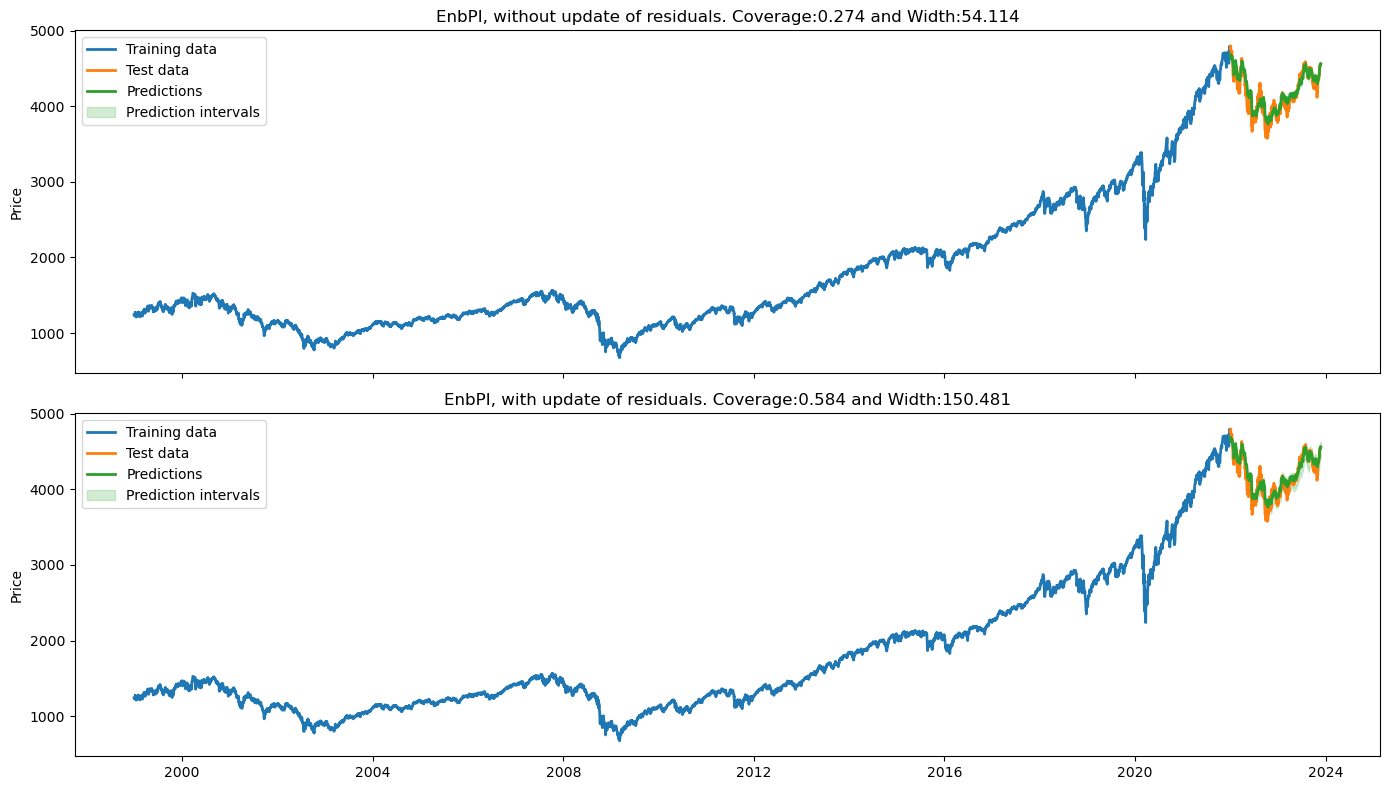

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Price")
    ax.plot(
        y_train,#[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
plt.show()

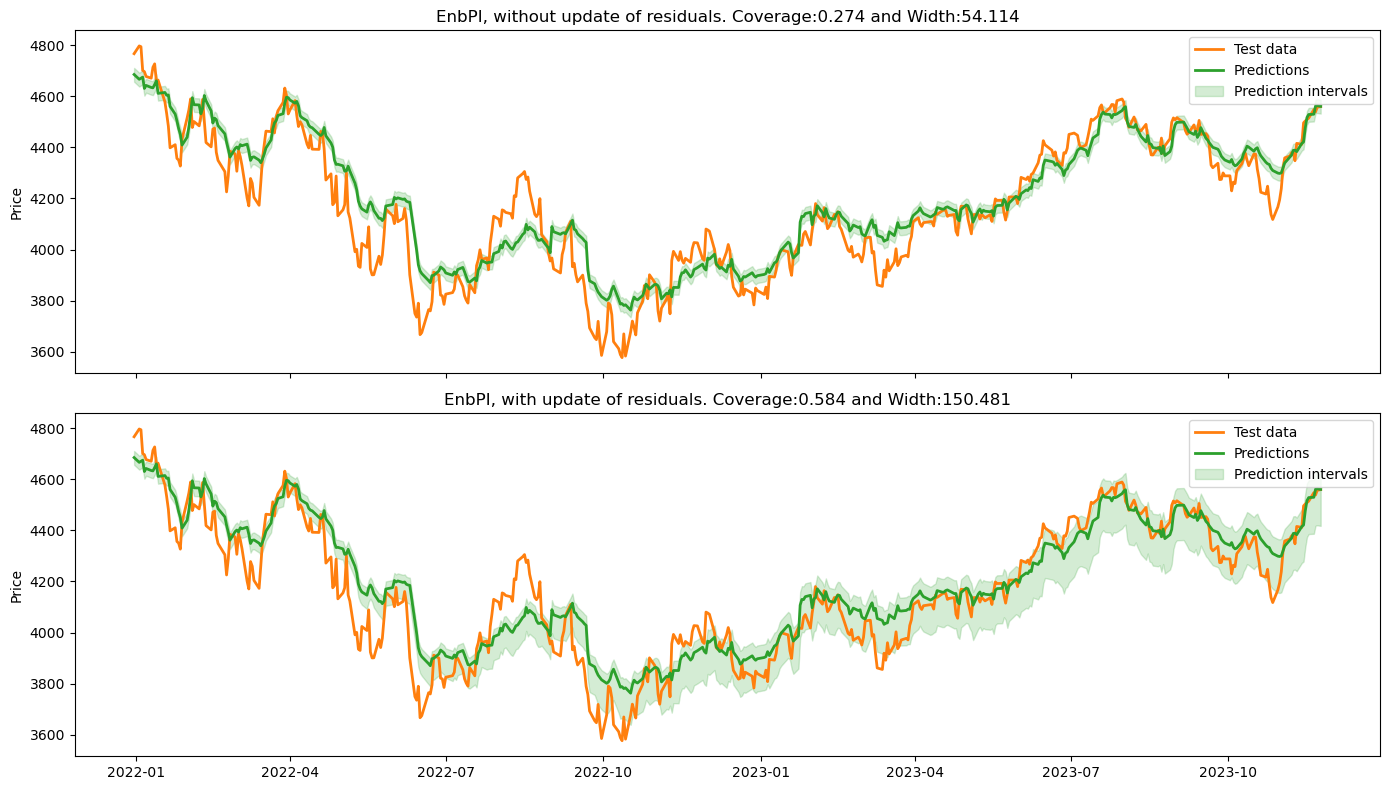

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]
y_test = y_test.sort_index()

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Price")
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
plt.show()

### Trading Strategy

Buy when upper prediction interval is crossed and hold until lower interval is crossed, then short and vice versa

In [13]:
price  = df['y']
preds = pd.Series(y_preds[1],index=y_test.index)

q1 = pd.Series(y_pis[1][:, 0, 0],index=y_test.index)
q2 =pd.Series(y_pis[1][:, 1, 0],index=y_test.index)
df_p = pd.concat([price,preds,q1,q2],axis=1)
df_p.columns  = ['price','pred','q1','q2']
df_p = df_p.dropna()

In [14]:
# initialisations
df_p = df_p.copy()  # create a new DataFrame to ensure you're not working on a view of other DataFrame
df_p.loc[:, 'position'] = 0
df_p.loc[:, 'change_in_price'] = df_p['price'].diff()
capital = 100.0  # capital base, it will change due to the portfolio return
capital_list = []
previous_row = None
now_position = 0  # this variable indicates the current position

for _, current_row in df_p.iterrows():
    if previous_row is not None:
        # if the price crosses the upper bound, go/buy long
        if (previous_row['price'] <= previous_row['q2']) and (current_row['price'] > current_row['q2']):
            now_position = 1
        # if the price crosses the lower bound, go/short sell
        elif (previous_row['price'] >= previous_row['q1']) and (current_row['price'] < current_row['q1']):
            now_position = -1
        df_p.loc[_, 'position'] = now_position
            
        # calculate return
        ret = df_p.loc[_, 'position'] * df_p.loc[_, 'change_in_price'] / previous_row['price']
        capital *= (1 + ret)
        capital_list.append(capital)
    previous_row = current_row

df_p = df_p.iloc[1:]  # drop the first row because it has no change or position

df_p.loc[:, 'capital'] = capital_list
df_p = df_p.iloc[1:]
df_p.loc[:, 'period_return'] = df_p['capital'].pct_change() + 1  # the daily return of your capital
df_p.loc[:, 'cumulative_return'] = df_p['capital'] / capital  # this is your capital growth rate

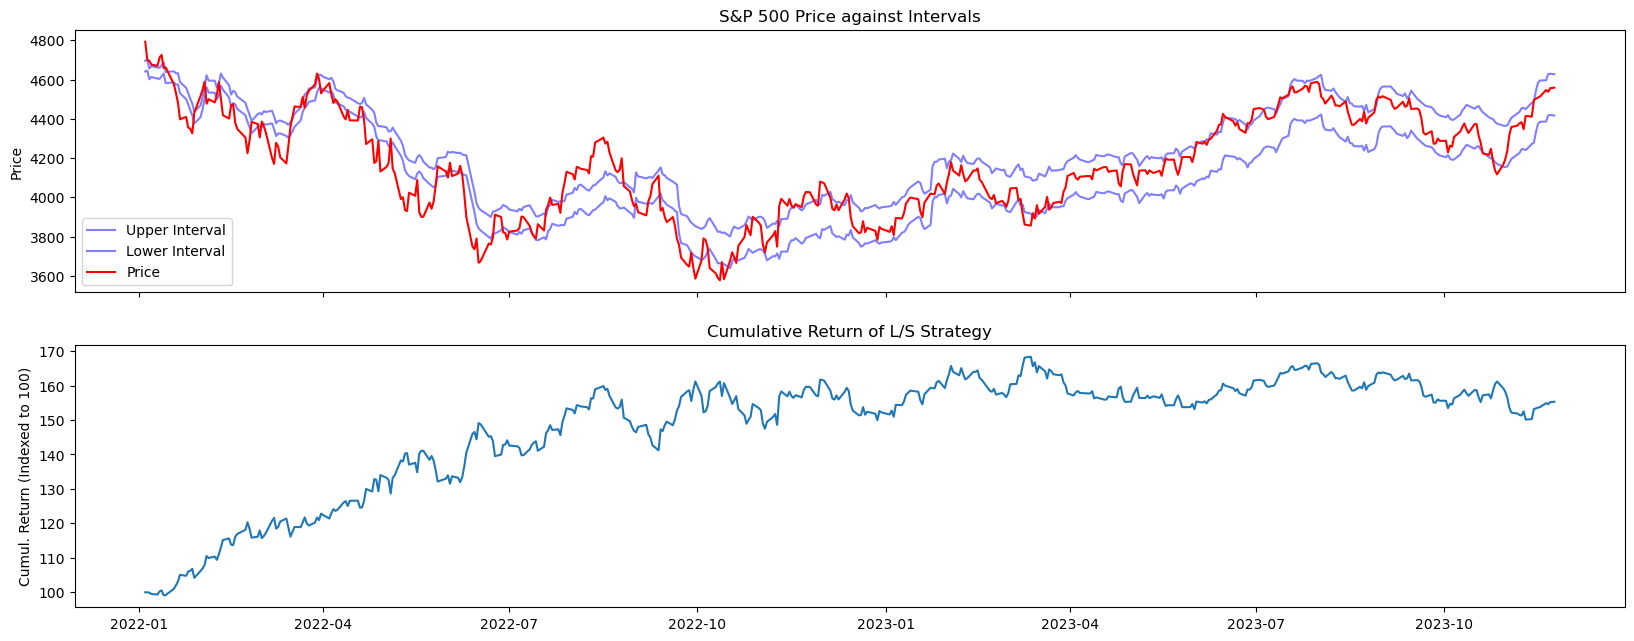

In [15]:
fig,axs = plt.subplots(2,figsize = (20,7.5),sharex=True)
axs[0].plot(df_p[['q1','q2']],color = 'blue',alpha=.5)
axs[0].plot(df_p['price'],color = 'red')
axs[0].set_title('S&P 500 Price against Intervals')
axs[0].legend(['Upper Interval','Lower Interval','Price'])
axs[0].set_ylabel("Price")

axs[1].plot(df_p['capital'])
axs[1].set_title('Cumulative Return of L/S Strategy')
axs[1].set_ylabel("Cumul. Return (Indexed to 100)")

plt.show()